In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("when_approach").config("hive.metastore.uris", "thrift://bialobog:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session
spark.sql("USE 2023_11_02")

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/hadoop-3.2.2/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/apache-hive-2.3.7-bin/lib/log4j-slf4j-impl-2.6.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2024-01-13 01:05:04,302 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-01-13 01:05:07,164 WARN spark.ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


DataFrame[]

In [2]:
from pyspark.sql.functions import lit,col
import pandas as pd
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
#from boruta import BorutaPy
#from fredapi import Fred
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
import csv
from pyspark.sql import functions as F
from functools import reduce
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from CreateDataset import get_features_all_stocks_seq, get_full_series_stocks, get_tabular_dataset, get_feature_col_names, get_not_null_cols
from pyspark.ml.feature import StandardScaler
from pyspark.sql.window import Window

In [3]:
def split_train_test(df, split_date):
    split_date = pd.to_datetime(split_date)
    train_df = df.filter(col('date')<split_date)
    test_df = df.filter(col('date')>=split_date)
    return train_df, test_df


def forward_fill(df):
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    feature_cols = df.columns[2:-1]
    for c in feature_cols:
        df = df.withColumn(
            c, F.last(c, ignorenulls=True).over(window_spec)
        )
    return df.orderBy('fsym_id','date')

def scale(train_df, test_df):
#     train_df = train_df.withColumn('year', F.year('date'))
#     test_df = test_df.withColumn('year', F.year('date'))
#     window_spec = Window().partitionBy('year')

#     feature_cols = train_df.columns[2:-1]

#     scaling_params = {}

#     for c in feature_cols:
#         mean_col = F.avg(F.col(c)).over(window_spec)
#         stddev_col = F.stddev(F.col(c)).over(window_spec)
#         epsilon = 1e-10

#         # Calculate mean and standard deviation for each year
#         train_means = train_df.select('year', mean_col.alias(c + '_mean')).distinct()
#         train_stddevs = train_df.select('year', stddev_col.alias(c + '_stddev')).distinct()

#         # Join means and stddevs back to the main dataframe
#         train_df = train_df.join(train_means, on='year', how='left').join(train_stddevs, on='year', how='left')

#         # Scale the column using the calculated mean and stddev
#         train_df = train_df.withColumn(c, (F.col(c) - F.col(c + '_mean')) / (F.col(c + '_stddev') + epsilon))

#         # Save scaling parameters
#         scaling_params[c] = {'mean_col': c + '_mean', 'stddev_col': c + '_stddev'}

#     for c, params in scaling_params.items():
#         # Scale the test set using the mean and stddev from the training set
#         test_df = test_df.withColumn(c, (F.col(c) - F.lit(params['mean_col'])) / F.lit(params['stddev_col']) + epsilon)

    return train_df, test_df


def write_features_file(data_list, csv_file_path='features.csv'):
    data_list = [data_list]
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in data_list:
            writer.writerow(row)
    print("Features written: ", data_list[0])

    

In [4]:
def get_df(all_feats=False, imploded_only=True):
    df = get_tabular_dataset(all_feats=all_feats, imploded_only=imploded_only)
    df = forward_fill(df)
    print("Number of rows: ", df.count())
    print("Number of positives: ", df.filter(F.col('label')==1).count())
    df=df.fillna(0.0)
    print("Number of rows after dropping nulls: ", df.count())
    print("Number of positives after dropping nulls: ", df.filter(F.col('label')==1).count())
    df.show(3)

    train_df, test_df = split_train_test(df, '2018-12-31')
    print(train_df.count()/df.count())
    print(test_df.count()/df.count())
    
    print("Number of positives in train set: ", train_df.filter(col('label')==1).count())
    print("Number of positives in test set: ", test_df.filter(col('label')==1).count())
    train_df, test_df = scale(train_df, test_df) #introduces null values for columns that are all 0 - come back to this
    # for c in train_df.columns:
    #     train_df.filter(F.col(c).isNull()).select(F.col(c)).show()
    return train_df, test_df


In [5]:
train_df, test_df = get_df()

/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


7312


7312


Number of rows:  4060


Number of positives:  502


Number of rows after dropping nulls:  4060


Number of positives after dropping nulls:  502


2024-01-13 01:05:59,059 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+----------+----------------------+------------------+---------------+-----------------+-----------+----------------------+-------+-----------------+----------------+---------+------------------+-------------------+------------------+--------------------------+-------+------------+--------------+---------------+----------+-----------------+----------+-----------+--------------------+----------+--------------------+-----------------+--------------------+-----------+-----------------+-----------+----+-----+
| fsym_id|      date|ff_net_inc_bef_xord_gr|   ff_capex_assets|ff_div_yld_secs|          ff_roic|ff_earn_yld|ff_debt_st_x_curr_port|ff_roce|   ff_oper_inc_gr|ff_reinvest_rate| ff_wkcap|ff_commiss_inc_net|ff_oper_cf_fix_chrg|ff_debt_entrpr_val|ff_net_inc_dil_bef_unusual|ff_xord|ff_xord_disc|ff_liabs_lease|ff_pfd_stk_tcap|ff_div_yld| ff_gross_cf_debt|ff_dil_adj|ff_sales_gr|  ff_net_inc_per_emp|ff_fcf_yld|     ff_non_oper_exp|       ff_roa_ptx|ff_dfd_tax_assets_lt|        GDP|Un

0.8096059113300492


0.19039408866995075


Number of positives in train set:  270


Number of positives in test set:  232


In [6]:
train_df.filter(F.col('fsym_id')=='B15GK7-R').show(30) #imploded egs B15GK7-R, B2JT9Z-R

+--------+----------+----------------------+---------------+---------------+-------+-----------+----------------------+-------+-----------------+----------------+---------+------------------+-------------------+------------------+--------------------------+-------+------------+--------------+---------------+----------+-----------------+----------+-----------+------------------+-----------+---------------+-----------------+--------------------+-----------+-----------------+-----------+----+-----+
| fsym_id|      date|ff_net_inc_bef_xord_gr|ff_capex_assets|ff_div_yld_secs|ff_roic|ff_earn_yld|ff_debt_st_x_curr_port|ff_roce|   ff_oper_inc_gr|ff_reinvest_rate| ff_wkcap|ff_commiss_inc_net|ff_oper_cf_fix_chrg|ff_debt_entrpr_val|ff_net_inc_dil_bef_unusual|ff_xord|ff_xord_disc|ff_liabs_lease|ff_pfd_stk_tcap|ff_div_yld| ff_gross_cf_debt|ff_dil_adj|ff_sales_gr|ff_net_inc_per_emp| ff_fcf_yld|ff_non_oper_exp|       ff_roa_ptx|ff_dfd_tax_assets_lt|        GDP|Unemployment_Rate|        CPI|year|label

In [7]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


def boruta_fs(train_df, test_df, model_name): #HOW DOES BORUTA ACC WORK?
    train_df = train_df.toPandas()
    test_df = test_df.toPandas()
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    X_test = test_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_test = test_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        model = GradientBoostingClassifier
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 5:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features


# train_df, test_df = get_df(all_feats=True)
# boruta_features = boruta_fs(train_df, test_df, 'rf')
# current_features = get_feature_col_names()
# for f in boruta_features:
#     if f in current_features:
#         print(f)
#final_features = list(set(boruta_features + current_features))
# write_features_file(final_features) #in the feature selection pipeline, 

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def correlation_matrix(df):
    df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.savefig('corr_matrix.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                
# correlation_matrix(train_df)

In [9]:
train_df = train_df.drop('ff_div_yld_secs', 'ff_earn_yld', 'ff_roa_ptx')
test_df = test_df.drop('ff_div_yld_secs', 'ff_earn_yld', 'ff_roa_ptx')

Converted to Pandas
INITIAL: 


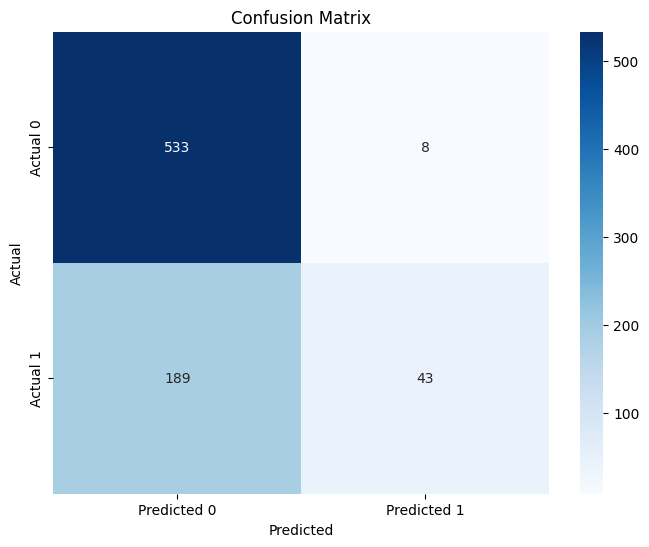

100%|██████████| 5/5 [00:46<00:00,  9.28s/trial, best loss: -0.32889586884112487]
TRAIN AND TEST FOR RandomForest


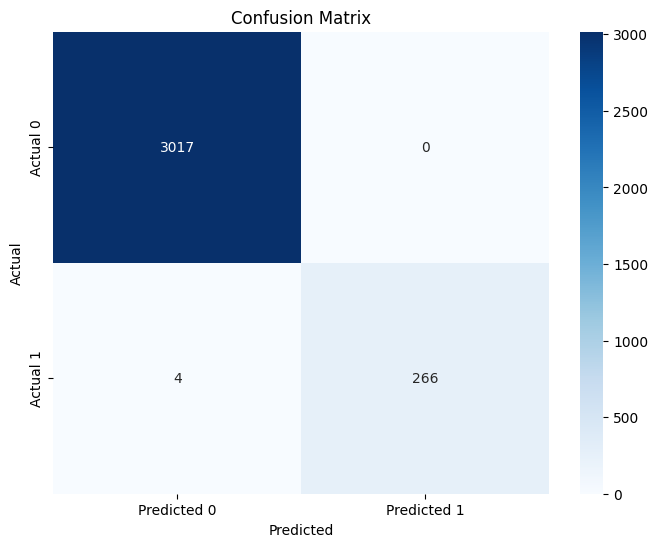

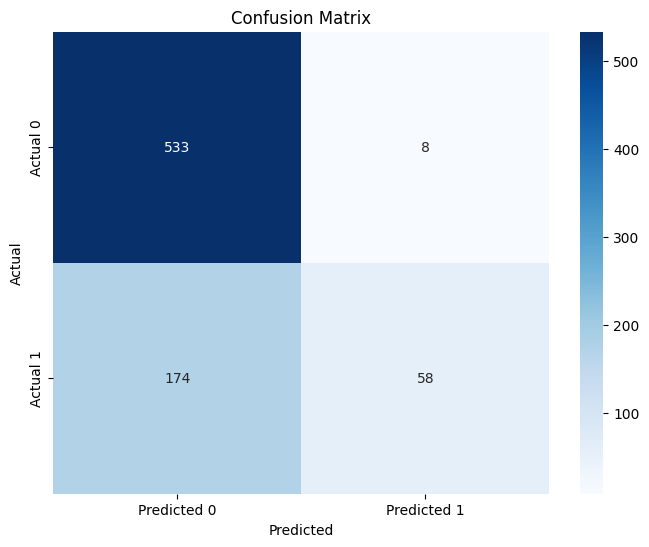

Feature Importances:
ff_net_inc_bef_xord_gr: 0.04736607734140759
ff_capex_assets: 0.034531359861073904
ff_roic: 0.039499315540590586
ff_debt_st_x_curr_port: 0.020487815825303086
ff_roce: 0.03919925790886517
ff_oper_inc_gr: 0.04899708410209053
ff_reinvest_rate: 0.03613039534111851
ff_wkcap: 0.04673560973164309
ff_commiss_inc_net: 0.01693568795430071
ff_oper_cf_fix_chrg: 0.03951004362651826
ff_debt_entrpr_val: 0.08607562108677246
ff_net_inc_dil_bef_unusual: 0.05937353219742015
ff_xord: 0.0023497514430280116
ff_xord_disc: 0.00990290712979339
ff_liabs_lease: 0.007219077730404816
ff_pfd_stk_tcap: 0.007205341602178719
ff_div_yld: 0.007397488323570837
ff_gross_cf_debt: 0.036925784735444105
ff_dil_adj: 0.0028689263215480555
ff_sales_gr: 0.04353847516139985
ff_net_inc_per_emp: 0.045432428205367484
ff_fcf_yld: 0.17276931428178022
ff_non_oper_exp: 0.05022098621784022
ff_dfd_tax_assets_lt: 0.007257375473445858
GDP: 0.022993272639623252
Unemployment_Rate: 0.021887004842039592
CPI: 0.024647847207943

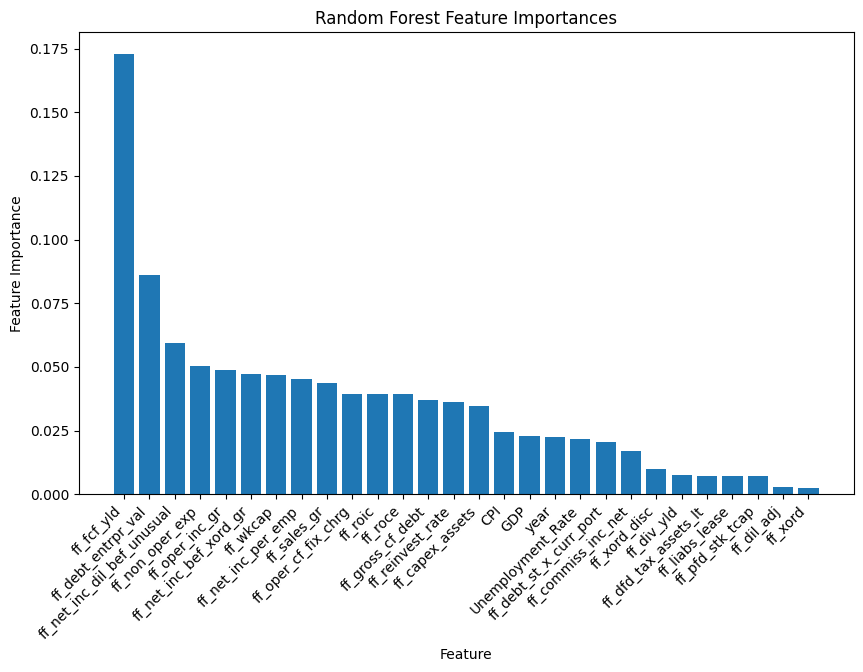

In [10]:
# from pyspark.ml.feature import VectorAssembler
# from pyspark.ml import Pipeline
# from pyspark.ml.linalg import Vectors, VectorUDT
# from pyspark.sql.functions import udf
# from pyspark.ml.regression import LinearRegression
# from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
# from pyspark.ml.evaluation import BinaryClassificationEvaluator
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
# from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp
from sklearn import tree
import shap

def confusion_matrix_pandas(df):
    """
    Create a confusion matrix as a Pandas DataFrame.

    Args:
        predictions (DataFrame): DataFrame containing 'label' and 'prediction' columns.
        label_col (str): Name of the column with actual labels.
        prediction_col (str): Name of the column with predicted labels.

    Returns:
        pd.DataFrame: Confusion matrix.
    """
    cm = confusion_matrix(df['label'], df['prediction'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    

def basic_test(train_df, test_df):
    feature_cols = train_df.columns[2:-1]
    print("Features: ", feature_cols)
    
    assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
    train_df = assembler.transform(train_df)
    test_df = assembler.transform(test_df)
    
    lr = LogisticRegression(labelCol='label', featuresCol='features')
    rf = RandomForestClassifier(featuresCol='features', labelCol='label')
    gb = GBTClassifier(labelCol='label', featuresCol='features')
    
    models = {'Logistic Regression': lr, 'Random Forest': rf, 'Gradient Boosting': gb}

    for model_name, model in models.items():
        print(f"\nResults for {model_name}:")
        trained_model = model.fit(train_df)
        
        preds_train_df = trained_model.transform(train_df)
        preds_test_df = trained_model.transform(test_df)
        #print(preds_train_df.show())
        
        # Train set confusion matrix
        confusion_matrix_pandas(preds_train_df.select('prediction', 'label'))
        
        # Test set confusion matrix
        confusion_matrix_pandas(preds_test_df.select('prediction', 'label'))
        
        # Area under the ROC curve
        evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC')
        auc_train = evaluator.evaluate(preds_train_df)
        auc_test = evaluator.evaluate(preds_test_df)
        
        print(f"\nArea under the ROC curve (AUC) - Train - {model_name}: {auc_train}")
        print(f"Area under the ROC curve (AUC) - Test - {model_name}: {auc_test}")
        
def feature_importances(model, features):
    feature_importances = model.feature_importances_

    print("Feature Importances:")
    for feature, importance in zip(features, feature_importances):
        print(f"{feature}: {importance}")

    sorted_idx = np.argsort(feature_importances)[::-1]
    sorted_features = [features[i] for i in sorted_idx]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
    plt.xticks(range(len(feature_importances)), sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title("Random Forest Feature Importances")
    plt.show()
    
def shapley(model, features, X_train):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_train)
    print(shap_values.shape)
    shap.plots.waterfall(shap_values[0])
    shap.plots.bar(shap_values)
        
def model_testing(train_df, test_df, classifier):
    train_df = train_df.toPandas()
    test_df = test_df.toPandas()
    print("Converted to Pandas")
    exclude_columns = ['fsym_id', 'date', 'label']
    
    X_train = train_df.drop(exclude_columns, axis=1)
    y_train = train_df['label']
    X_test = test_df.drop(exclude_columns, axis=1)
    y_test = test_df['label']
    
    if classifier == 'LogisticRegression':
        param_space = {
            'C': hp.uniform('C', 0.01, 1.0)
        }
        classifier_instance = LogisticRegression()
    elif classifier == 'RandomForest':
        param_space = { 
            'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
            'max_depth': hp.quniform('max_depth', 5, 20, 1)
        }
        classifier_instance = RandomForestClassifier()
    elif classifier == 'GBT':
        param_space = { 'n_estimators':hp.uniform('n_estimators',100,500),
           'max_depth':hp.quniform('max_depth',5,20,1),
           'min_samples_leaf':hp.quniform('min_samples_leaf',1,5,1),
           'min_samples_split':hp.quniform('min_samples_split',2,6,1)}
        classifier_instance = GradientBoostingClassifier()
    else:
        raise ValueError("Unsupported classifier")
    tscv = TimeSeriesSplit(n_splits=5)
    
    def set_params(classifier, params):
        if classifier == 'RandomForest':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'GBT':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            params['min_samples_leaf'] = int(params['min_samples_leaf'])
            params['min_samples_split'] = int(params['min_samples_split'])
            return params
        else:
            return params
        
    def objective(params):
        params = set_params(classifier, params)
        classifier_instance.set_params(**params)
        scores = cross_val_score(classifier_instance, X_train, y_train, cv=tscv, scoring='f1')
        score = -scores.mean()
        return score
    
    initial_model = classifier_instance
    initial_model = initial_model.fit(X_train, y_train)
    initial_preds = pd.DataFrame()
    print("INITIAL: ")
    initial_preds['prediction'] = initial_model.predict(X_test)
    initial_preds['label'] = y_test
    confusion_matrix_pandas(initial_preds)
    
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=5)
    
    best_params = set_params(classifier, best_params)
    classifier_instance.set_params(**best_params)
    classifier_instance.fit(X_train, y_train)
    train_preds = pd.DataFrame()
    train_preds['prediction'] = classifier_instance.predict(X_train)
    train_preds['label'] = y_train
    print(f"TRAIN AND TEST FOR {classifier}")
    confusion_matrix_pandas(train_preds)
    
    test_preds = pd.DataFrame()
    test_preds['prediction'] = classifier_instance.predict(X_test)
    test_preds['label'] = y_test
    confusion_matrix_pandas(test_preds)
    if classifier != 'LogisticRegression':
        feature_importances(classifier_instance, X_train.columns.tolist())
    
        
        

model_testing(train_df, test_df, 'RandomForest')
# basic_test(train_df, test_df)

In [11]:
import shap

In [12]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

def cross_val(train_df, test_df):
    feature_cols = train_df.columns[2:-1]
    print("Features: ",feature_cols)
    assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
    lr = LogisticRegression(labelCol='label', featuresCol = 'features')
    rf = RandomForestClassifier(featuresCol="features", labelCol="label")
    gb = GBTClassifier(labelCol='label', featuresCol = 'features')
    
    classifiers = [lr, rf, gb]
    
    cv_models = []
    
    evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol="rawPrediction", metricName='areaUnderROC')
    
    for classifier in classifiers:
        print("Starting...")
        pipeline = Pipeline(stages=[assembler, classifier])
        
        paramGrid = ParamGridBuilder() \
        .addGrid(classifier.regParam, [0.01, 0.1]) \
        .addGrid(classifier.elasticNetParam, [0.0, 0.5]) \
        .addGrid(classifier.maxIter, [10, 20]) \
        .build()
        
        cross_val = CrossValidator(
            estimator=pipeline,
            estimatorParamMaps=paramGrid,
            evaluator=evaluator,
            numFolds=5
        )
        
        cv_model = cross_val.fit(train_df)
        cv_models.append(cv_model)
        print("Working")
    
    for cv_model in cv_models:
        predictions = cv_model.transform(test_df)
        auc = evaluator.evaluate(predictions)
        print(f"Model AUC: {auc}")
        
def basic_test(train_df, test_df):
    feature_cols = train_df.columns[2:-1]
    print("Features: ",feature_cols)
    assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
    train_df = assembler.transform(train_df)
    test_df = assembler.transform(test_df)
    lr = LogisticRegression(labelCol='label', featuresCol = 'features')
    rf = RandomForestClassifier(featuresCol="features", labelCol="label")
    gb = GBTClassifier(labelCol='label', featuresCol = 'features')
    
    evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol="rawPrediction", metricName='areaUnderROC')
    
    lr = lr.fit(train_df)
    preds_train_df = lr.transform(train_df)
    preds_test_df = lr.transform(test_df)
    
    
def cross_val_pandas(train_df, test_df):
    train_df = train_df.toPandas()
    test_df = test_df.toPandas()
    print("Converted to Pandas")
    exclude_columns = ['fsym_id', 'date', 'label']
    
    X_train = train_df.drop(exclude_columns, axis=1)
    y_train = train_df['label']
    X_test = test_df.drop(exclude_columns, axis=1)
    y_test = test_df['label']
    models = {
        'Logistic Regression': LogisticRegression(),
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC(probability=True),
        'Gradient Boosting': GradientBoostingClassifier()
    }

    param_grids = {
        'Logistic Regression': {
            'C': [0.01, 0.1, 1.0, 10.0],
            'max_iter': [100, 200, 300]
        },
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20]
        },
        'SVM': {
            'C': [0.1, 1.0, 10.0],
            'kernel': ['linear', 'rbf']
        },
        'Gradient Boosting': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    }
    tscv = TimeSeriesSplit(n_splits=5)

    for model_name, model in models.items():
        param_grid = param_grids[model_name]

        grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='roc_auc')

        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_

        predictions = best_model.predict(X_test)

        auc = roc_auc_score(y_test, predictions)

        print(f"\nResults for {model_name}:")
        print(f"Area under the ROC curve (AUC): {auc}")
        print("Best model hyperparameters:")
        print(grid_search.best_params_)
        
        # Confusion matrix
        cm = confusion_matrix(y_test, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        

#model_testing(train_df, test_df)
#cross_val_pandas(train_df, test_df)

In [15]:
spark.stop()